In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from utils import histogram
import torch
from torch.utils.data import DataLoader, TensorDataset

# 1 Dataset

In [5]:
from utils import load_svhn_dataset, visualize_class_distr, plot_images, plot_transformed_images, Standardizer, create_vectors

In [6]:
# Provide the paths to SVHN train and test datasets
train_path = '/Users/louis.skowronek/PycharmProjects/pattern_recognition/term-project/train_32x32.mat'
test_path = '/Users/louis.skowronek/PycharmProjects/pattern_recognition/term-project/test_32x32.mat'

train_images, train_labels, test_images, test_labels = load_svhn_dataset(train_path, test_path)

# print shapes
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (73257, 32, 32, 3)
Train labels shape: (73257,)
Test images shape: (26032, 32, 32, 3)
Test labels shape: (26032,)


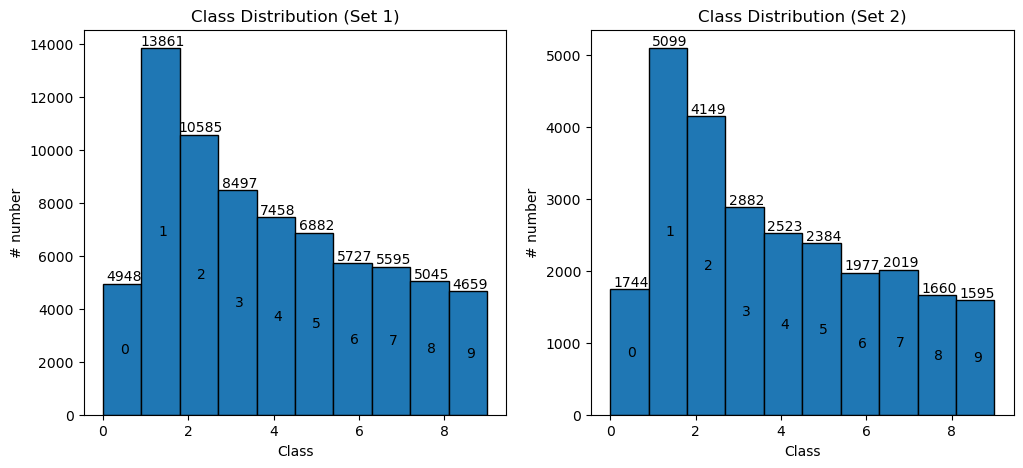

In [23]:
visualize_class_distr(train_labels, test_labels)

Observations: 
- train and test samples come from the same class distribution
- we have an slightly unbalanced dataset where a majority of samples belong to class 1. Class zero is the least prominent one. 
- because of that accuracy might not be the best choice for evaluation, but rather precision, recall or f1-score. To keep it simple I am going to stick with accuracy

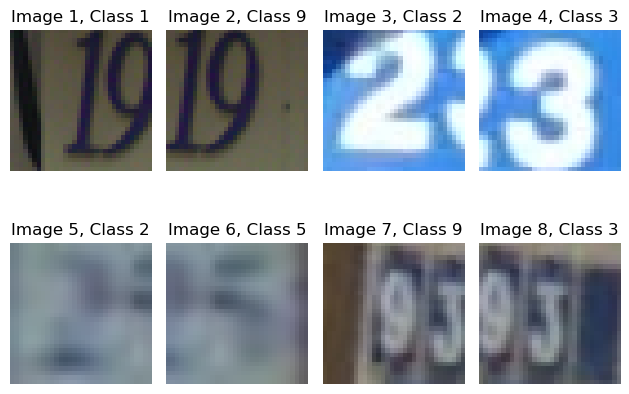

In [24]:
plot_images(train_images, train_labels, rows=2, cols=4)

Challenges in the SVHN dataset:
- we have multiple numbers shown in one image. 
- Sometimes the numbers are really hard to identify (e.g. image 4 and 5)

-> this makes the problem of identifying the correct numbers harder

# 2 Feature Extraction

### 1.  rgb histogram

for each channel (rgb) create an histogram. Append all values in a final feature vector

In [553]:
from feature_extraction import rgb_histogram

In [554]:
rgb_train_images = rgb_histogram(train_images)
rgb_test_images = rgb_histogram(test_images)

100%|███████████████████████████████████| 26032/26032 [00:03<00:00, 8145.84it/s]


In [555]:
rgb_train_images.shape

(73257, 3, 256)

In [556]:
# flatten features
rgb_train_features = create_vectors(rgb_train_images)
rgb_test_features = create_vectors(rgb_test_images)

In [557]:
# standardize features
scaler = Standardizer(library='numpy')
rgb_train_features = scaler.fit_transform(rgb_train_features)
rgb_test_features = scaler.transform(rgb_test_features)

In [558]:
rgb_train_features.shape

(73257, 768)

### 2. grey scaled images with average pooling

1. convert rgb images to grey scale images
2. reduce dimensionality by using average pooling to reduce the 32x32 images to 16x16

In [7]:
from feature_extraction import gray_reduced_images

In [55]:
gray_train_images = gray_reduced_images(train_images)
gray_test_images = gray_reduced_images(test_images)

100%|██████████████████████████████████| 26032/26032 [00:01<00:00, 23712.41it/s]


In [561]:
gray_train_images.shape

(73257, 16, 16, 1)

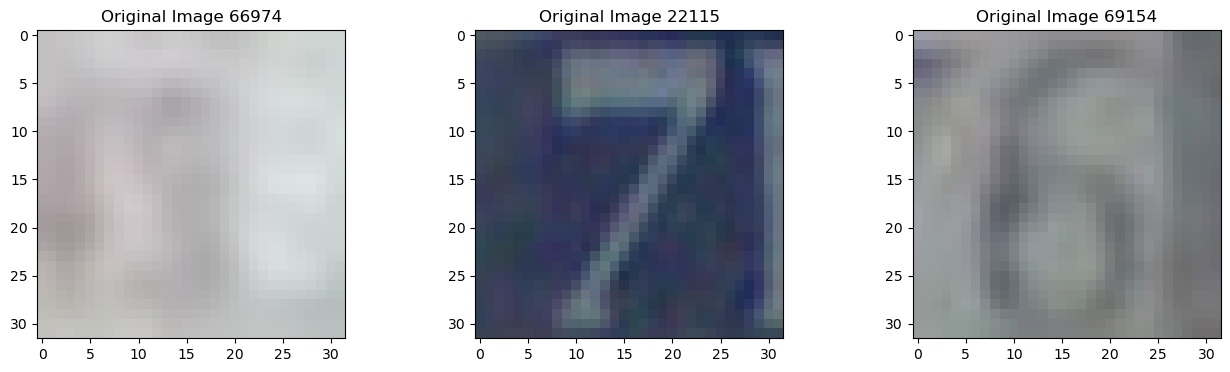

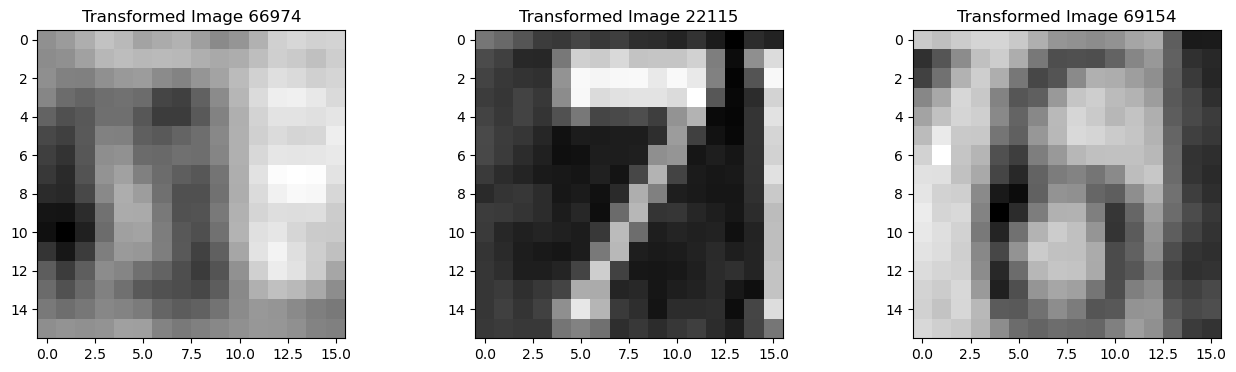

In [563]:
plot_transformed_images(train_images, gray_train_images)

In [56]:
# create feature vectors
gray_train_features = create_vectors(gray_train_images)
gray_test_features = create_vectors(gray_test_images)

In [57]:
# standardize features
scaler = Standardizer(library='numpy')
gray_train_features = scaler.fit_transform(gray_train_features)
gray_test_features = scaler.transform(gray_test_features)

In [58]:
gray_train_features.shape

(73257, 256)

### 3. Local Binary Pattern

In [62]:
from feature_extraction import grid_search_lbp, lbp

plotting the local binary patterns for different HP values for n_random different images

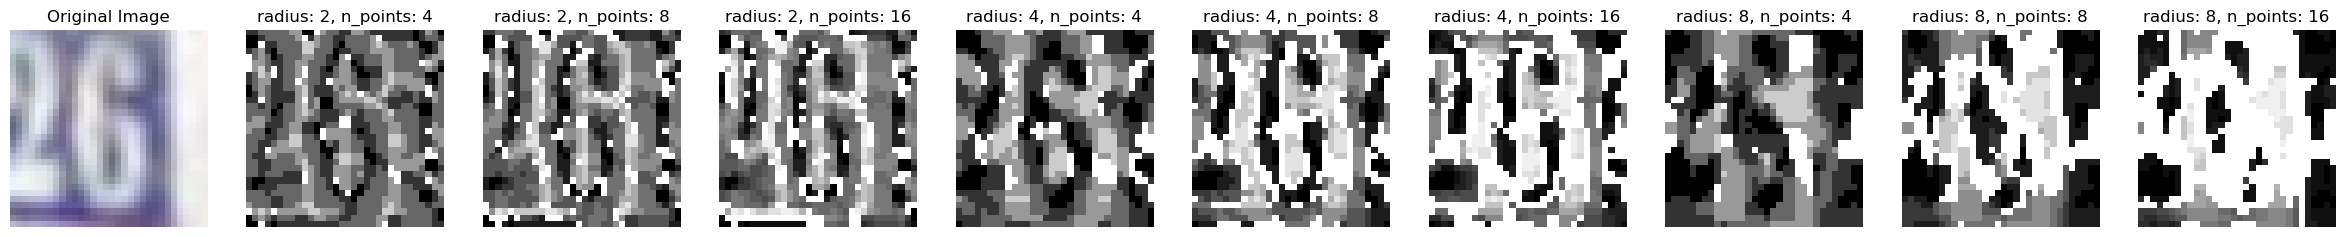

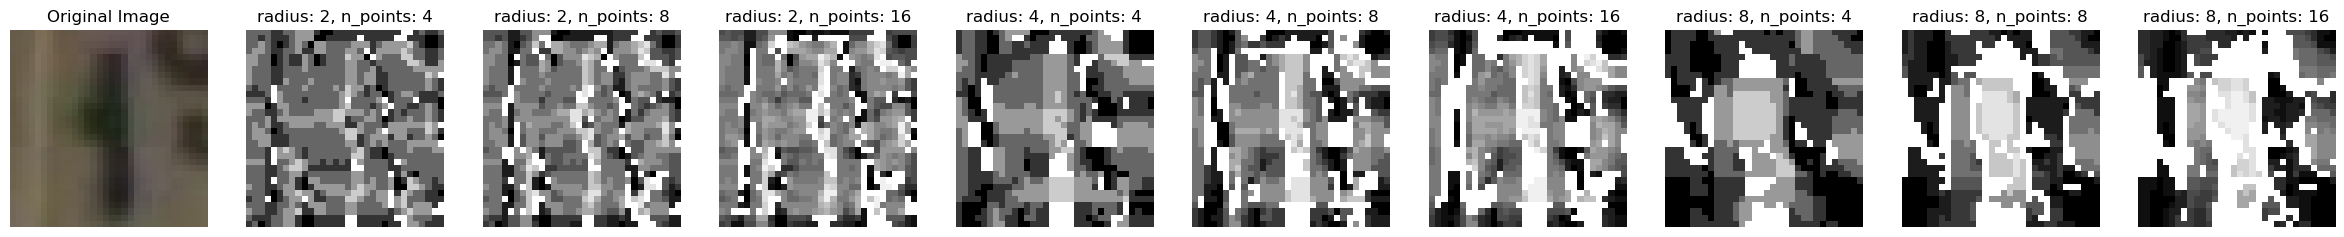

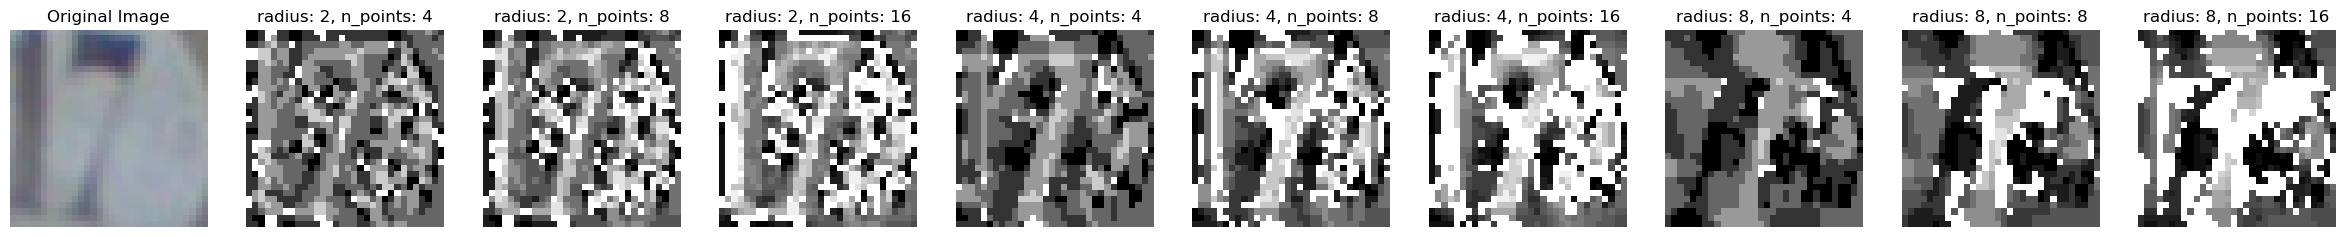

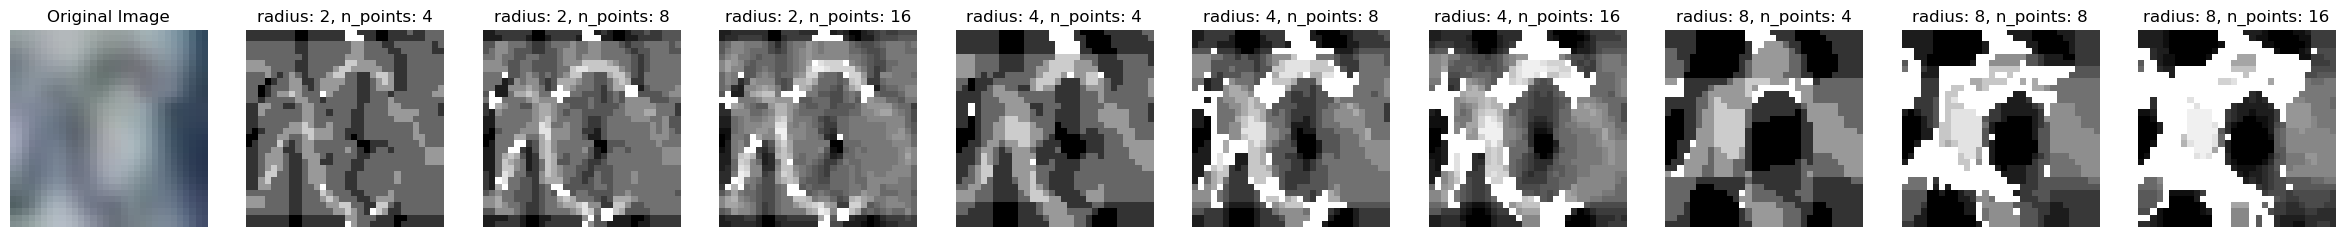

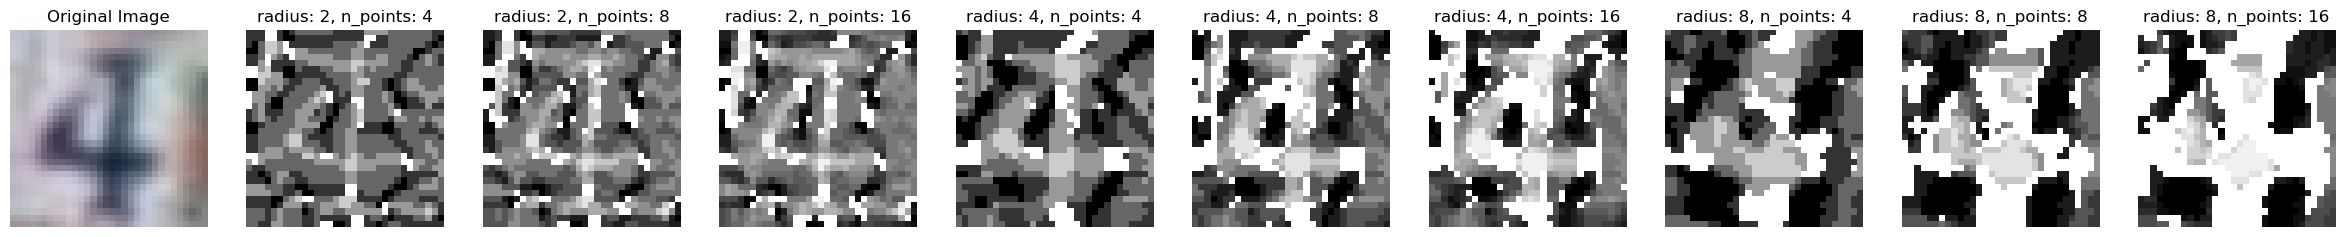

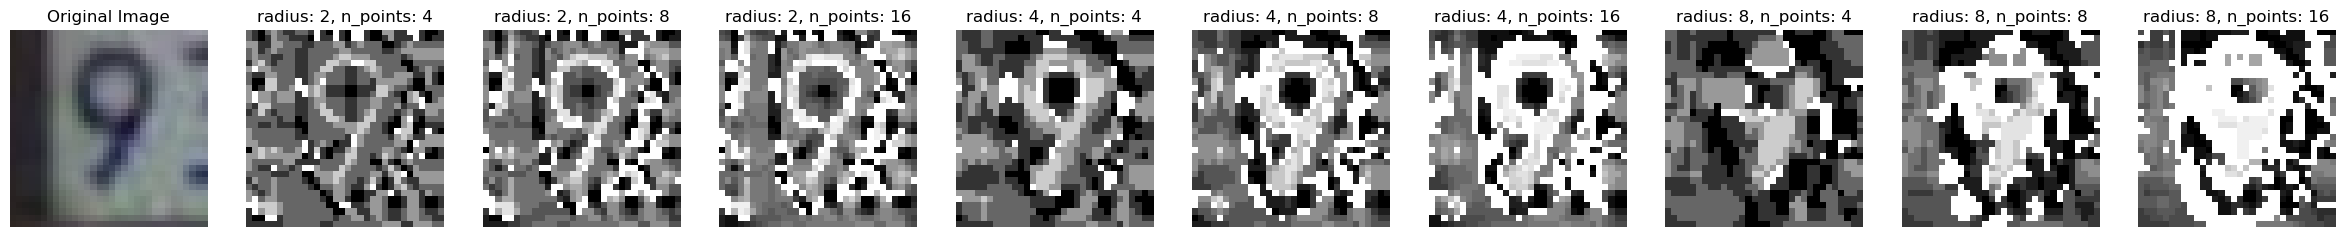

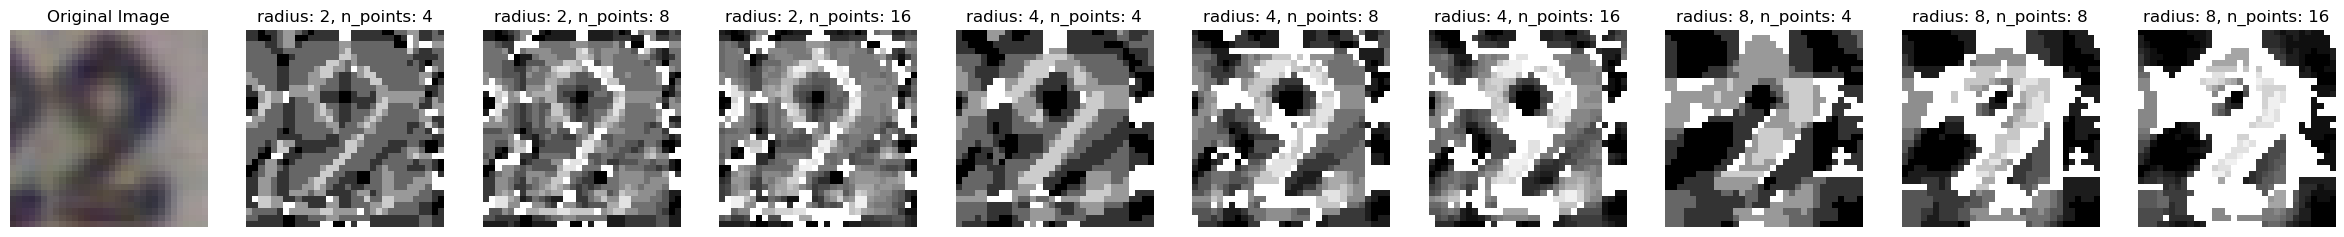

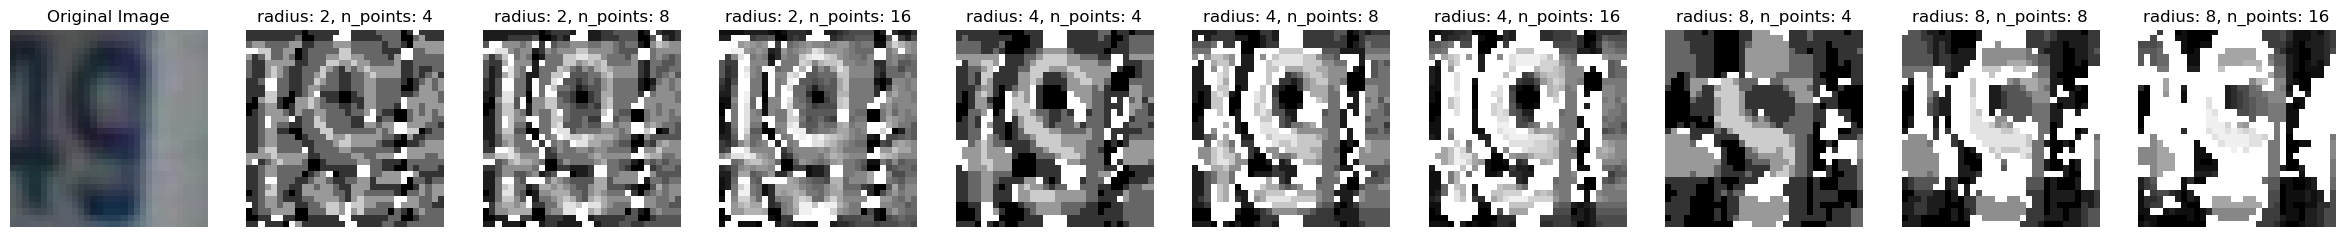

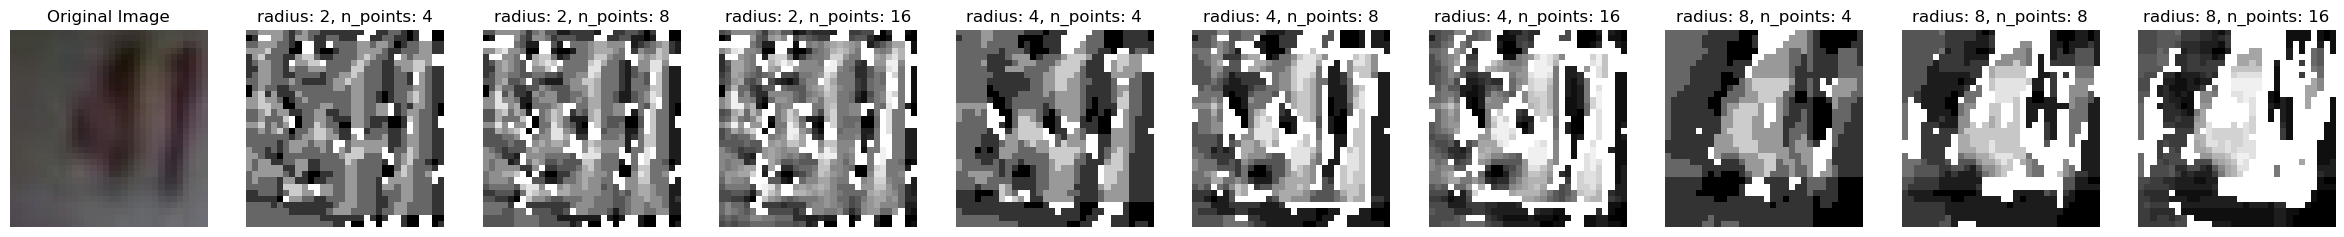

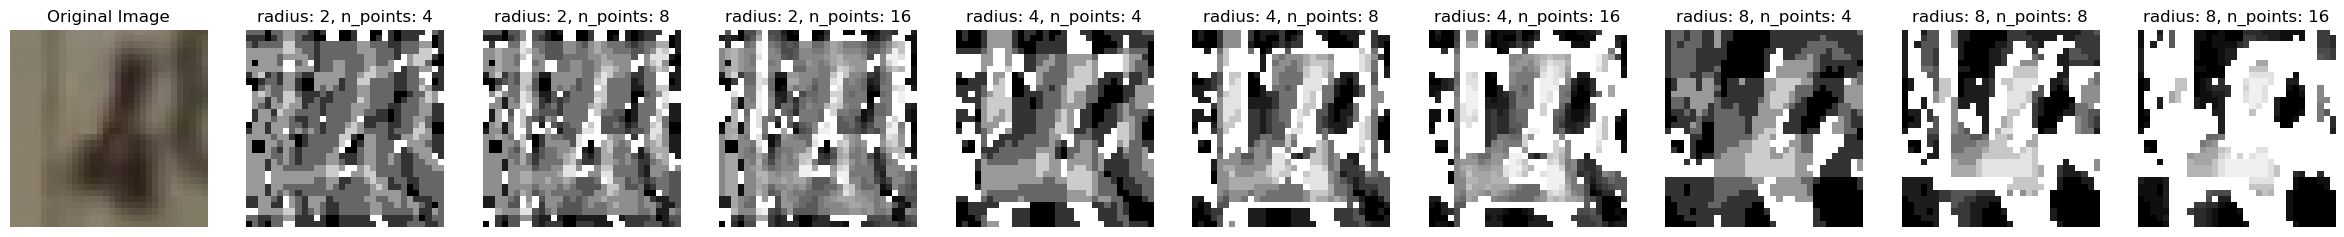

In [531]:
grid_search_lbp(train_images, n_random = 10, radius_values=[2, 4, 8], n_points_values=[4, 8, 16])

Observations: 
- the quality of the local binary patterns depend on the hyperparameter "radius" and "n_points"
- finding a good value is difficult. One value seems to work fine on one image, but gives poor results on another image
- It challenging to select a reasonable one based on the results
- sometimes the number is white (pixel value close to 255) and sometimes the number is dark (pixel value close to 0). Having enough training samples we should have enough bright and dark examples from the same class
- I go with radius:4, n_points:16. It seems to work fairly well, unfortunately it still has quite some noise

In [63]:
lbp_train_images = lbp(train_images, radius=4, n_points=16)
lbp_test_images = lbp(test_images, radius=4, n_points=16)

100%|██████████████████████████████████| 26032/26032 [00:02<00:00, 11085.28it/s]


In [64]:
lbp_train_images.shape

(73257, 32, 32, 1)

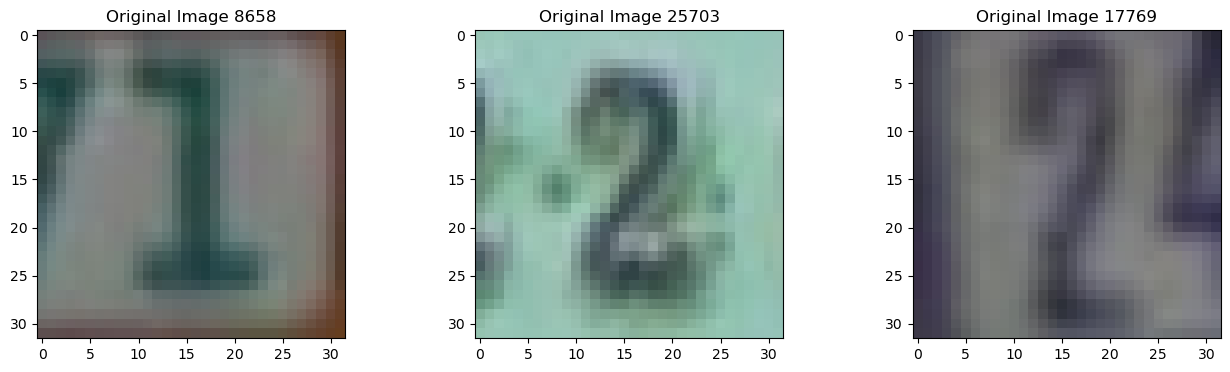

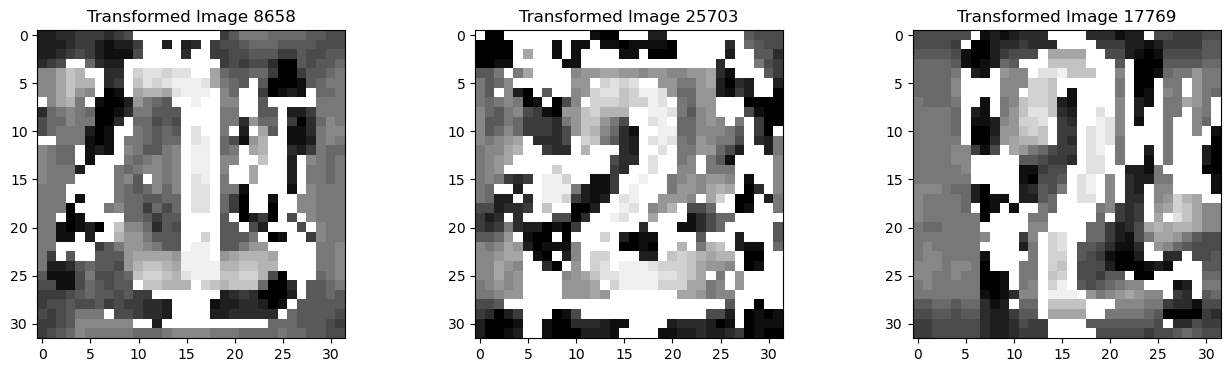

In [571]:
plot_transformed_images(train_images, lbp_train_images)

In [65]:
# get histograms based on the images
lbp_train_features = histogram(lbp_train_images, bins=64)
lbp_test_features = histogram(lbp_test_images, bins=64)

In [66]:
# standardize features
scaler = Standardizer(library='numpy')
lbp_train_features = scaler.fit_transform(lbp_train_features)
lbp_test_features = scaler.transform(lbp_test_features)

In [67]:
lbp_train_features.shape

(73257, 64)

### 4. Harris Corner Detection

In [575]:
from feature_extraction import hcd

In [576]:
hcd_train_images = hcd(train_images)
hcd_test_images = hcd(test_images)

100%|██████████████████████████████████| 26032/26032 [00:00<00:00, 58366.51it/s]


In [577]:
hcd_train_images.shape

(73257, 32, 32, 1)

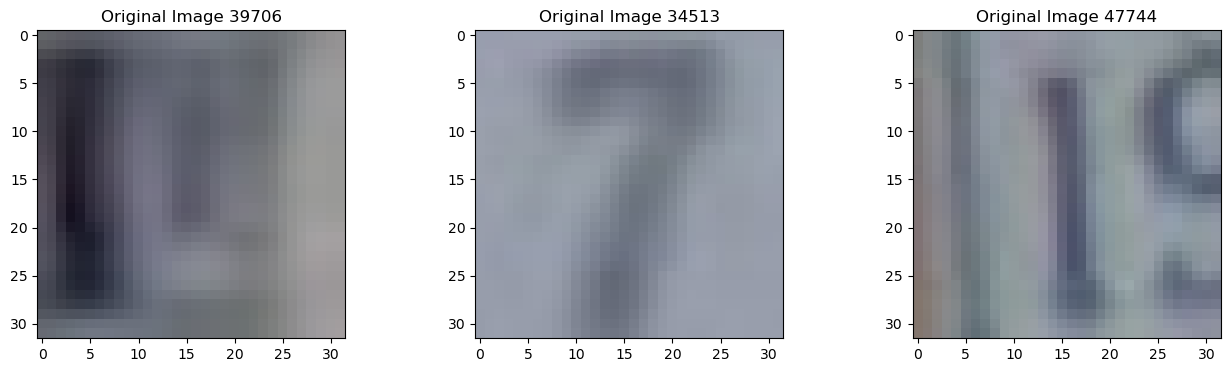

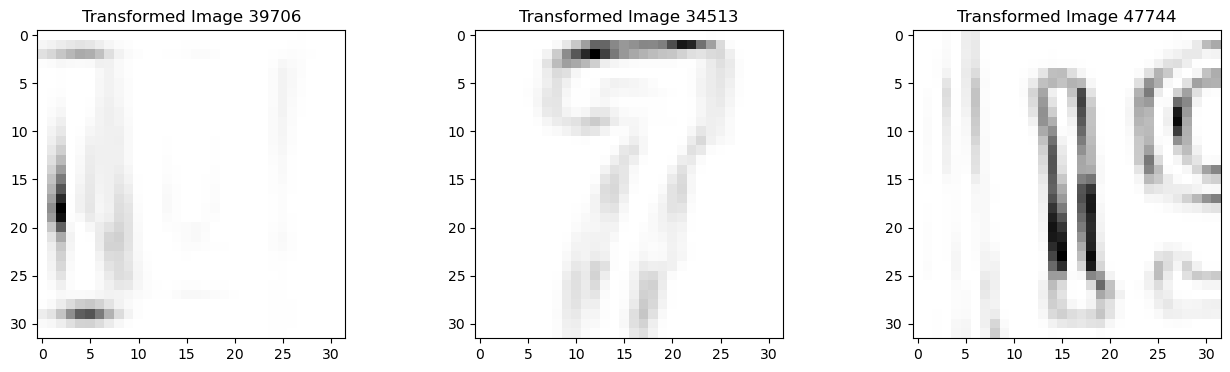

In [581]:
plot_transformed_images(train_images, hcd_train_images)

Observations:
- fairly well able to detect the edges of the numbers
- still problematic that it also detects the edges of the other irrelevant numbers in the image

In [582]:
hcd_train_features = histogram(hcd_train_images, bins=64)
hcd_test_features = histogram(hcd_test_images, bins=64)

In [583]:
# standardize features
scaler = Standardizer(library='numpy')
hcd_train_features = scaler.fit_transform(hcd_train_features)
hcd_test_features = scaler.transform(hcd_test_features)

In [584]:
hcd_train_features.shape

(73257, 64)

### 5. ORB and then Visual Bag of Words

In [112]:
from feature_extraction import orb_sift, histogram_visual_words

In [586]:
train_descriptors = orb_sift(train_images, method='orb') # I don't calculate SIFT Features here, but I implemented them already so I can use the code for task 4 
test_descriptors = orb_sift(test_images, method='orb')

100%|███████████████████████████████████| 26032/26032 [00:03<00:00, 7687.25it/s]


In [403]:
# do kmeans clustering for all descriptors
features = np.concatenate([inner_array for inner_array in train_descriptors if inner_array is not None])

n_clusters = 50
kmeans = KMeans(n_clusters, n_init=5)  # Number of clusters (visual words)
kmeans.fit(features)

/Users/louis.skowronek/miniforge3/envs/aiss_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=50)

In [587]:
orb_train_features = histogram_visual_words(kmeans, train_descriptors, bins=n_clusters)
orb_test_features = histogram_visual_words(kmeans, test_descriptors, bins=n_clusters)

100%|███████████████████████████████████| 26032/26032 [00:03<00:00, 7708.37it/s]


In [588]:
# standardize features
scaler = Standardizer(library='numpy')
orb_train_features = scaler.fit_transform(orb_train_features)
orb_test_features = scaler.transform(orb_test_features)

In [589]:
orb_train_features.shape

(73257, 50)

## 2.2 Quantifying the distinctivness of the features 

- I am using silhouette coefficient to compare the distinctivness of the features.
- Silhouette coefficient is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It lays between [-1,1] while a high value is desirable.
- Due to computational constraints, I can't use the full dataset to compute the evaluation metric. I am only using a subsample of 20 000 entries randomly chosen (stratified sampling). This is not ideal, but hopefully gives me a good approximation for the whole dataset.

In [590]:
from feature_extraction import silhouette_coefficient, print_results

In [591]:
# feature_extraction containing the features from 5 different feature extraction techniques
features = {'rgb': rgb_train_features, 
            'gray': gray_train_features,
            'lbp': lbp_train_features,
            'hcd': hcd_train_features,
            'orb': orb_train_features}

results = {}

for key, feature in features.items(): 
    
    silhouette_values, silhouette_mean = silhouette_coefficient(feature, train_labels, subsample=20000)
    
    results[key] = [silhouette_values, silhouette_mean]

calculating distance matrix: 100%|██████████████| 20/20 [00:06<00:00,  3.33it/s]
calculating silhouette coefficient: 100%|█| 20000/20000 [00:23<00:00, 858.13it/s
calculating distance matrix: 100%|██████████████| 20/20 [00:04<00:00,  4.41it/s]
calculating silhouette coefficient: 100%|█| 20000/20000 [00:23<00:00, 863.20it/s
calculating distance matrix: 100%|██████████████| 20/20 [00:02<00:00,  8.18it/s]
calculating silhouette coefficient: 100%|█| 20000/20000 [00:23<00:00, 840.07it/s
calculating distance matrix: 100%|██████████████| 20/20 [00:02<00:00,  8.39it/s]
calculating silhouette coefficient: 100%|█| 20000/20000 [00:23<00:00, 868.71it/s
calculating distance matrix: 100%|██████████████| 20/20 [00:02<00:00,  8.58it/s]
calculating silhouette coefficient: 100%|█| 20000/20000 [00:23<00:00, 861.89it/s


In [592]:
print_results(results)

  Technique  Silhouette Coefficient
2       lbp                 0.00905
4       orb                 0.00323
1      gray                 0.00008
3       hcd                -0.00327
0       rgb                -0.00556
----------------------------------------------------------------------
Best results obtained by feature extraction technique lbp: 0.00905


Observations:
- based on the chosen evaluation method, lbp gives the best results
- however the qualities of the clusters based on the evaluation metrics is not good
- I experimented with many different hyperparameters for the methods but could not improve the results

### 2.3 Investigate classes with low intra-class similarities and high inter-class similarities

- For lpb, the silhouette coefficient for individual classes is obtained. Low values point towards low intra-class similarity and high inter-class similarity

In [ ]:
from feature_extraction import plot_sh_coeff

In [593]:
# get the silhouette coefficient for individual classes for the lbp feature
X, _, y, _ = train_test_split(lbp_train_features, train_labels, stratify=train_labels, train_size=20000, random_state=42)

# get the average silhouette values for each class
silhouette_values = results['lbp'][0]

classes = list(set(y))
overview = pd.DataFrame(index = classes, columns = ['silhouette_coeff'])

for c in classes:
    overview.loc[c, 'silhouette_coeff'] = silhouette_values[y==c].mean()

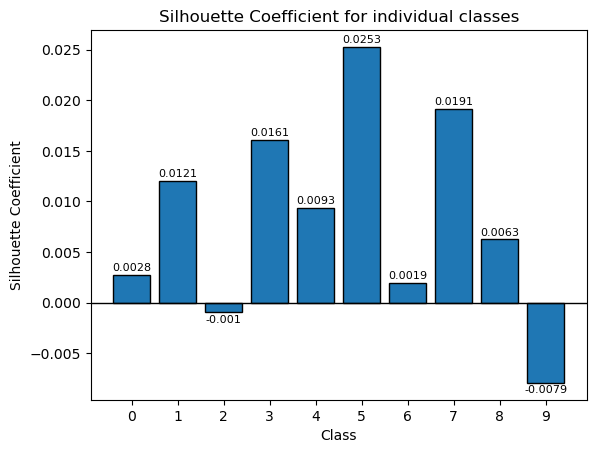

In [594]:
plot_sh_coeff(overview)

Observation:
- based on the chosen metric, the features for the classes 3, 5 and 7 are the best (highest silhouette coefficient). 
- Problematic classes might be class 2 and class 9 (lowest silhouette coefficient)
- as stated before, the silhouette coefficient is pretty low indicating that performance of the classifier won't be good possibly

# 3. Classification

## 3.1 Use K-nearest Neighbor for classification

Challenges: 
- how to determine the best hyperparameter for k to avoid overfitting/underfitting?
- Proposed solution: split the train data further into a train set and dev set. Perform a grid search: for multiple values of k train a k-NN on the train set and evaluate performance on the dev set. Choose the k with the best performance (accuracy as a evaluation metric). Based on this k train a k-NN an all training data and test generalization capabilities on the separate test set.

- here I have implemented grid search myself. Later I am using gridsearchCV from sklearn

In [36]:
from classification import knn_grid_search, knn_train_test

In [596]:
X_test, y_test = lbp_test_features, test_labels
X_train, X_valid, y_train, y_valid = train_test_split(lbp_train_features, train_labels, random_state=42, shuffle=True, stratify=train_labels, train_size=0.8)

In [597]:
list_k = [3,5,10,20,40,60,80,100,150,200,300,400,500,600,800,1000]

result_knn, best_k = knn_grid_search(list_k, X_train, y_train, X_valid, y_valid)

fit k-NN with different values of k: 100%|██████| 16/16 [01:44<00:00,  6.53s/it]

      acc_train  acc_valid
k                         
3      0.507397   0.211302
5      0.451531   0.220243
10     0.381077   0.236486
20     0.340773   0.251024
40     0.315604   0.258804
60     0.303012   0.265220
80     0.295965   0.268223
100    0.291938   0.266380
150    0.284976   0.268701
200    0.280829   0.267813
300    0.273816   0.266312
400    0.270250   0.262968
500    0.265660   0.260442
600    0.262759   0.258190
800    0.257572   0.255870
1000   0.253681   0.249249
----------------------------------------------------------------------
Best results obtained for k = 150


train the model with the best found value of k

In [598]:
model = knn_train_test(X_train, X_test, y_train, y_test, best_k)

Accuracy on train set: 0.285
Accuracy on test set 0.274


## 3.2 Use linear discriminant functions for classification

Chosen classifiers:
I use Linear Discriminant Analysis, Logistic Regression and Support Vector Machines. 
I get non-linear transformation of the features by using SVC with various kernel function 

Hyperparameter selection: 
For each model I select the hyperparameter based on a grid search with k-fold cross validation. For that reason I limit the amount of overfitting. I have reported, training, validation and test accuracy.

In [17]:
import warnings
from sklearn.exceptions import FitFailedWarning
from classification import train_tune_test

warnings.filterwarnings("ignore", category=FitFailedWarning)

In [104]:
X_train, y_train, X_test, y_test = lbp_train_features, train_labels, lbp_test_features, test_labels

### 1. Linear Discriminant Analysis

In [69]:
# Define a grid of hyperparameters to search over, with separate entries for different solvers
param_grid = [
    {'solver': ['svd']},
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.01, 0.001, 0.0001]}
]

model = train_tune_test(LinearDiscriminantAnalysis(), param_grid, X_train, y_train, X_test, y_test, cv=4)

/Users/louis.skowronek/miniforge3/envs/aiss_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.24519155 0.2451779         nan 0.24519155 0.24519155 0.24431791
 0.24431791 0.24532806 0.24532806 0.24519155 0.24519155 0.2451779
 0.2451779 ]
  warnings.warn(




accuracy on train set: 0.246
accuracy on validation set: 0.245
accuracy on test set: 0.257


Observation: 
- for certain hyperparameter combinations the algorithm fails to converge which results in an non-finite score 

### 2. Logistic Regression

In [602]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30],  # Regularization strength
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']  # Solver 
}

model = train_tune_test(LogisticRegression(), param_grid, X_train, y_train, X_test, y_test, cv=4)



accuracy on train set: 0.247
accuracy on validation set: 0.246
accuracy on test set: 0.261


Observation: 
- all fits converge as long as the features are properly scaled. Without applying standardization of the features, this method often fails to converge

### 3. Linear Support Vector Classifier  

In [74]:
param_grid = {
    'penalty':['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 2, 10]  # Regularization strength
}

model = train_tune_test(LinearSVC(dual=False), param_grid, X_train, y_train, X_test, y_test, cv=4)

/Users/louis.skowronek/miniforge3/envs/aiss_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/louis.skowronek/miniforge3/envs/aiss_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/louis.skowronek/miniforge3/envs/aiss_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/louis.skowronek/miniforge3/envs/aiss_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/louis.skowronek/miniforge3/envs/aiss_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iter



accuracy on train set: 0.24
accuracy on validation set: 0.24
accuracy on test set: 0.256


/Users/louis.skowronek/miniforge3/envs/aiss_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Observation:
- This linear model also has problems converging

### 4. Support Vector Classifier (non-linear transformations)

I only use a single train/val split to determine the hyperparameter. Doing Cross Validation takes too long, due to the limited computational resources.

In [101]:
from classification import DataSplit

In [653]:
param_grid = {
    'C': [0.1, 1, 5, 10],  # Regularization strength,  # Regularization strength
    'kernel': ['poly', 'rbf']  # Types of kernels
}

# get a single 80/20 split
splitter = DataSplit(test_size=0.2)

model = train_tune_test(SVC(probability=False), param_grid, X_train, y_train, X_test, y_test, cv=splitter)



accuracy on train set: 0.332
accuracy on validation set: 0.29
accuracy on test set: 0.311


Observations: 
- the SVM using non-linear transformations (by applying kernel trick) achieve the highest accuracy.

## 3.3 Do you observe any overfitting/underfitting?

I did not observe underfitting/overfitting as train, val and test error is pretty much the same. That's because I used k-fold cross validation to select the best hyperparameters. I also applied regularization. However, to not keep this section empty I visualized for k-NN the influence of k-NN for different values of k

In [495]:
from classification import plot_error

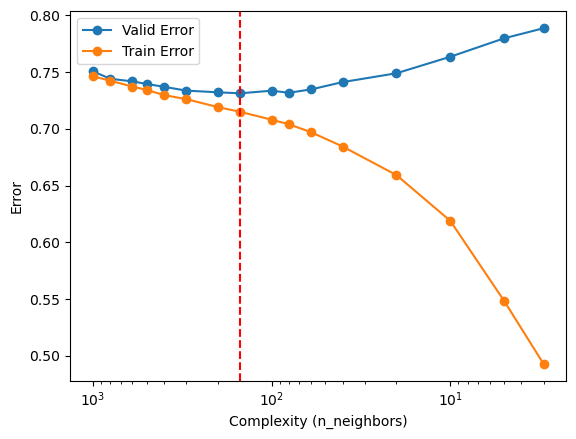

In [632]:
plot_error(result_knn)

This graph shows the error (1-accuracy) for training and validation set for different values of k. The vertical red bar marks the number of k which leads to the lowest validation error. In general, a value smaller than 150 leads to overfitting, while a value greater than 150 leads to underfitting.

# 4. Metric Learning

## 1. Implement distance metric learning framework

How to ensure that W is a valid distance matrics:
W needs to be Positive Semi definite (PSD). This is achieved by the Cholesky decomposition. Where $ W=LL^T $ and where $ L $ is a lower triangular matrix. Therefore, we learn the matrix L during training (and also a bias).

In [122]:
def initialize_values(size):
    # define weight matrix and bias
    L = torch.randn(size, size, requires_grad=True)
    
    b = torch.randn(1, requires_grad=True)
    
    return L, b


def forward(X, L, b):
    
    # Ensure L is lower triangular
    L_lower_triangular = torch.tril(L)

    # Compute W as L * L^T to ensure W is PSD
    W = torch.mm(L_lower_triangular, L_lower_triangular.t())

    X_trans = torch.matmul(X, W) + b
    
    return X_trans


def loss_function(distances, label_matrix, margin = 10):
    
    # if two samples from different classes are closer together than the margin -> penalize it
    
    # Calculate the loss for different classes, where only positive parts contribute to the loss. 
    similar_class_loss = (label_matrix * distances).sum() 

    # The margin is defined for penalizing instances if samples of two different classes are closer together than the margin
    different_class_loss = ((1 - label_matrix)*torch.clamp(margin - distances, min=0)).sum()

    # Total loss is the sum of the two parts
    loss = similar_class_loss + different_class_loss
    
    # For comparability scale the loss
    loss = loss / label_matrix.numel()
    
    return loss


# update w and b. Use a simple gradient descent
def update(L, b, lr):
    
    with torch.no_grad():
        L -= lr * L.grad
        b -= lr * b.grad
    
        L.grad.zero_()
        b.grad.zero_()
    
    return L, b


def learn_metric(L, b, dl_train, dl_valid, lr, num_epochs, margin, early_stopping):

    i = 0
    train_loss_list = []
    val_loss_list = []
    best_val_loss = np.inf

    for epoch in tqdm(range(num_epochs)):

        train_loss_batch = []

        for X_batch, y_batch in dl_train: 

            X_trans = forward(X_batch, L, b)

            # calculate the pairwise euclidean distances
            distances = torch.cdist(X_trans, X_trans, p=2)

            # calculate a matrix where there is a 1 if the label is the same and a 0 if the label is not the same
            label_matrix = (y_batch.unsqueeze(0) == y_batch.unsqueeze(1)).int()

            # Calculate Loss
            train_loss = loss_function(distances, label_matrix, margin)
            train_loss_batch.append(train_loss.detach().numpy())

            # Backward pass to compute gradients
            train_loss.backward()

            # perform update step
            L, b = update(L, b, lr)

        # Validate performance on valid set
        val_loss = validate(dl_valid, L, b)

        train_loss_list.append(np.mean(train_loss_batch))
        val_loss_list.append(val_loss)

        # Add early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            i = 0
        else:
            i += 1

        if i >= early_stopping:
            print(f'Loss has not improved for {early_stopping} Epochs. End training')
            break
            
    return L, b, train_loss_list, val_loss_list


def validate(dl, L, b):
    
    loss_list = []

    for X_batch, y_batch in dl: 
        
        X_trans = forward(X_batch, L, b)

         # calculate the pairwise euclidean distances
        distances = torch.cdist(X_trans, X_trans, p=2)

        # calculate a matrix where there is a 1 if the label is the same and a 0 if the label is not the same
        label_matrix = (y_batch.unsqueeze(0) == y_batch.unsqueeze(1)).int()

        # Calculate Loss
        loss = loss_function(distances, label_matrix, margin)
        loss_list.append(loss.detach().numpy())
        
    return np.mean(loss_list)

## 2. Create SIFT features and train metric learning framework

In [110]:
from metric_learning import plot_loss

create SIFT Features using the defined function from above

In [113]:
train_descriptors = orb_sift(train_images, method='sift')
test_descriptors = orb_sift(test_images, method='sift')

# do kmeans clustering for all descriptors
features = np.concatenate([inner_array for inner_array in train_descriptors if inner_array is not None])

n_clusters = 32
kmeans = KMeans(n_clusters, n_init=5)  # Number of clusters (visual words)
kmeans.fit(features)

sift_train_features = histogram_visual_words(kmeans, train_descriptors, bins=n_clusters)
sift_test_features = histogram_visual_words(kmeans, test_descriptors, bins=n_clusters)

[ WARN:0@61316.511] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736
100%|███████████████████████████████████| 26032/26032 [00:03<00:00, 8470.41it/s]


In [120]:
# Define dataset and dataloader. Get a separate validation dataset for avoiding overfitting
x_train, x_valid, y_train, y_valid = train_test_split(torch.tensor(sift_train_features).float(), torch.tensor(train_labels), train_size=0.8, stratify=train_labels)

x_test = torch.tensor(sift_test_features).float()
y_test = torch.tensor(test_labels)

ds_train = TensorDataset(x_train, y_train)
dl_train = DataLoader(ds_train, batch_size=2048, shuffle=True)

ds_valid = TensorDataset(x_valid, y_valid)
dl_valid = DataLoader(ds_valid, batch_size=2048, shuffle=False)

ds_test = TensorDataset(x_test, y_test)
dl_test = DataLoader(ds_test, batch_size=2048, shuffle=False)

In [123]:
# define HP
lr = 0.01
margin = 5 
early_stopping = 5
num_epochs = 1000

# initialize weight matrix and bias with random numbers
dim = x_train.size(1)
L, b = initialize_values(dim)

# adapt L and b using mini batch stochastic gradient descent
L, b, train_loss_list, val_loss_list = learn_metric(L, b, dl_train, dl_valid, lr, num_epochs, margin, early_stopping)

100%|███████████████████████████████████████| 1000/1000 [25:42<00:00,  1.54s/it]


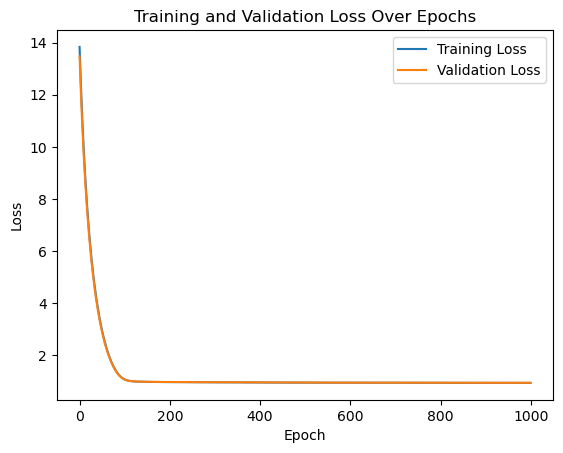

In [125]:
# Plot the training and validation loss
plot_loss(train_loss_list, val_loss_list)

I train the model for multiple epochs and use early stopping to automatically stop the training based on the loss of a separate validation set. However, the validation accuracy always decreases, not triggering the early stopping until the max number of epochs is reached (1000).

### Compare Performance of original SIFT features vs. learned SIFT features

In [126]:
param_grid = {
    'C': [0.1, 1, 5, 10], # Regularization strength
    'kernel': ['poly', 'rbf'],  # Types of kernels
}

# get a single 80/20 split
splitter = DataSplit(test_size=0.2)

In [115]:
X_train, X_test, y_train, y_test = sift_train_features, sift_test_features, train_labels, test_labels

scaler = Standardizer(library='numpy')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Train a classifier on the original SIFT features.')
model = train_tune_test(SVC(probability=False), param_grid, X_train, y_train, X_test, y_test, cv=splitter)

Train a classifier on the original SIFT features.


accuracy on train set: 0.378
accuracy on validation set: 0.26
accuracy on test set: 0.263


In [131]:
# transform features using the learned metric
sift_train_features_trans = forward(torch.tensor(sift_train_features).float(), L, b).detach().numpy()
sift_test_features_trans = forward(torch.tensor(sift_test_features).float(), L, b).detach().numpy()

X_train, X_test, y_train, y_test = sift_train_features_trans, sift_test_features_trans, train_labels, test_labels

scaler = Standardizer(library='numpy')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Train a classifier on the learned SIFT features')
model = train_tune_test(SVC(probability=False), param_grid, X_train, y_train, X_test, y_test, cv=splitter)

Train a classifier on the learned SIFT features


accuracy on train set: 0.337
accuracy on validation set: 0.244
accuracy on test set: 0.254


The Performance of the SVM Classifier using SIFT to extract keypoints from the image and using visual bag of words approach to create unique histogram for each image lead to an accuracy of 26.3% on the test set. Even though I used Cross Validation with Grid Search, there might be some overfitting because the train accuracy is considerably higher than the test accuracy. However cross validating more hyperparameter combinations would have been to time consuming due to long computing time.

The performance of the SVM Classifier using the learned SIFT Features leads to a decrease in performance, unfortunately. The test accuracy drops by 0.9% and is now at 25.4% for the test set. This indicates, that the learning algorithm does not learn a meaningful projection of the features for the classification task. I experimented with different learning rates and margins (hyperparameter for the loss function), but could not improve the results.